In [115]:
import base64
import IPython.display as ipd
%matplotlib inline
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import soundfile as sf
import time
import wave

# Original Audio

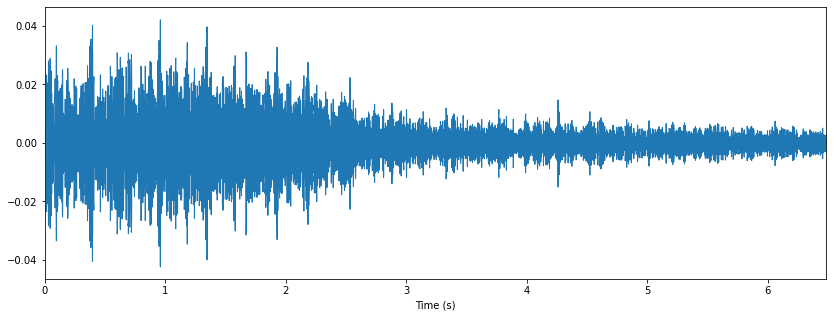

In [116]:
# open file and process at most one million frames
with wave.open('airplane.wav') as fd:
    params = fd.getparams()
    frames = fd.readframes(1000000)
    
# time and sampling rate    
x, sr = librosa.load('airplane.wav')

# show high level wave plot
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr, x_axis='s')

# process media for audio file
ipd.Audio(x, rate=sr)

142751 distinct values


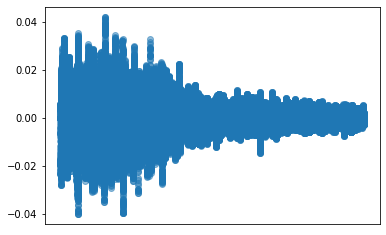

In [117]:
# convert to bytes and load into numpy array
x_bytes = x.tobytes()
y = np.frombuffer(x_bytes,dtype=numpy.float32)

# show number of unique values
(unique, counts) = np.unique(y, return_counts=True)
frequencies = numpy.asarray((unique, counts)).T
print(len(frequencies), "distinct values")

# create scatterplot representation
nx = np.arange(0,len(y))
ny = y
plt.scatter(nx, ny, alpha=0.5)
plt.xticks([])
#plt.yticks([])
plt.show()

# AES-GCM

## Encryption

In [131]:
from cryptography.hazmat.primitives.ciphers.aead import AESGCM

t0 = time.time()
aad = b"authenticated but unencrypted data"
nonce = os.urandom(12)
key = AESGCM.generate_key(bit_length=128)
aesgcm = AESGCM(key)
gct = aesgcm.encrypt(nonce, x_bytes, aad)
t1 = time.time()
print("Time taken to encrypt:",t1-t0,"seconds")

gcm_wav = numpy.frombuffer(gct,dtype=numpy.float32)
sf.write('encrypted_file_gcm.wav', gcm_wav, sr)

Time taken to encrypt: 0.002489805221557617 seconds


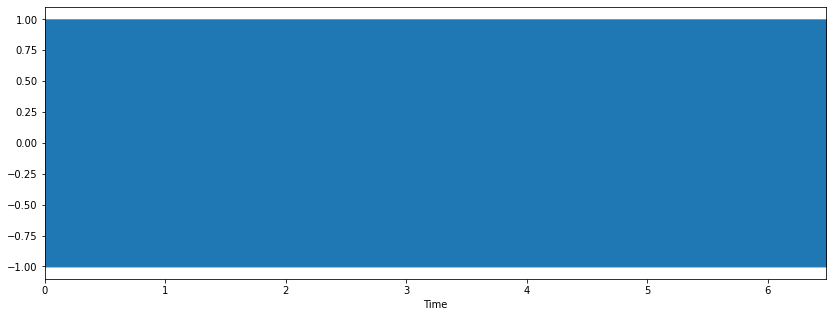

In [132]:
with wave.open('encrypted_file_gcm.wav') as fd:
    params = fd.getparams()
    frames = fd.readframes(1000000) 
    
gcm_x, gcm_sr = librosa.load('encrypted_file_gcm.wav')

plt.figure(figsize=(14, 5))
librosa.display.waveplot(gcm_x, sr=gcm_sr)
ipd.Audio(gcm_x, rate=sr)

3955 distinct values
Variance: 0.5082486


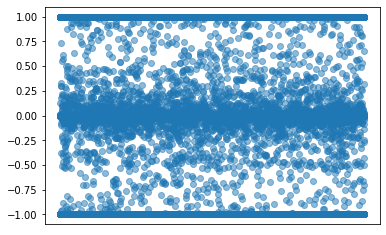

In [133]:
x = np.arange(0,len(gcm_x))
y = gcm_x

(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(len(frequencies), "distinct values")
print("Variance:", np.var(y))

plt.scatter(x, y, alpha=0.5)
plt.xticks([])
plt.show()

## Decryption

Time taken to encrypt: 0.0010449886322021484 seconds


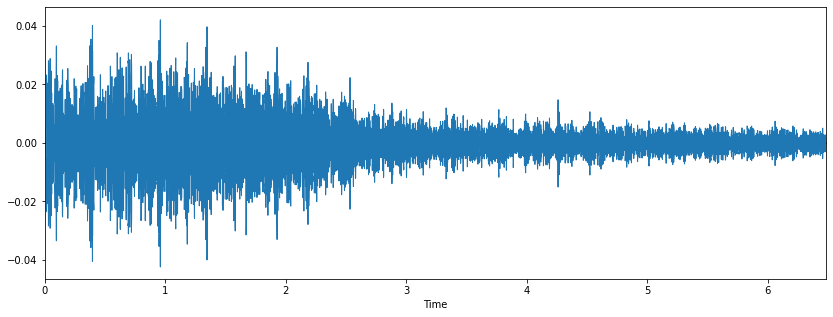

In [134]:
t0 = time.time()
gpt = aesgcm.decrypt(nonce, gct, aad)
t1 = time.time()
print("Time taken to decrypt:",t1-t0,"seconds")
daes_wav = numpy.frombuffer(gpt,dtype=numpy.float32)
sf.write('decrypted_file_gcm.wav', daes_wav, sr)

with wave.open('decrypted_file_gcm.wav') as fd:
    params = fd.getparams()
    frames = fd.readframes(1000000) 
    
gcmd_x, gcmd_sr = librosa.load('decrypted_file_gcm.wav')

# decrypted values should match original file and representations
plt.figure(figsize=(14, 5))
librosa.display.waveplot(gcmd_x, sr=gcmd_sr)
ipd.Audio(gcmd_x, rate=gcmd_sr)

# AES-CCM

## Encryption

In [135]:
from cryptography.hazmat.primitives.ciphers.aead import AESCCM

t0 = time.time()
aad = b"authenticated but unencrypted data"
nonce = os.urandom(12)
key = AESCCM.generate_key(bit_length=128)
aesccm = AESCCM(key)
cct = aesccm.encrypt(nonce, x_bytes, aad)
t1 = time.time()
print("Time taken to encrypt:",t1-t0,"seconds")

ccm_wav = numpy.frombuffer(cct,dtype=numpy.float32)
sf.write('encrypted_file_ccm.wav', ccm_wav, sr)

Time taken to encrypt: 0.002527952194213867 seconds


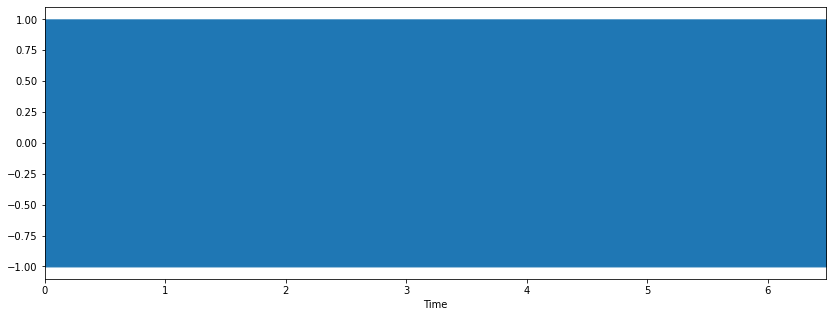

In [136]:
with wave.open('encrypted_file_ccm.wav') as fd:
    params = fd.getparams()
    frames = fd.readframes(1000000) 
    
ccm_x, ccm_sr = librosa.load('encrypted_file_ccm.wav')

plt.figure(figsize=(14, 5))
librosa.display.waveplot(ccm_x, sr=ccm_sr)
ipd.Audio(ccm_x, rate=sr)

3885 distinct values
Variance: 0.50579894


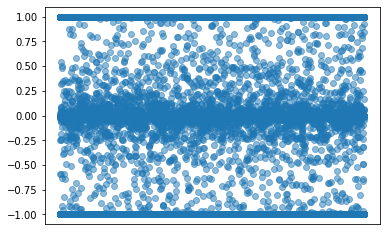

In [137]:
x = np.arange(0,len(ccm_x))
y = ccm_x

(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(len(frequencies), "distinct values")
print("Variance:", np.var(y))

plt.scatter(x, y, alpha=0.5)
plt.xticks([])
plt.show()

## Decryption

Time taken to decrypt: 0.0007507801055908203 seconds


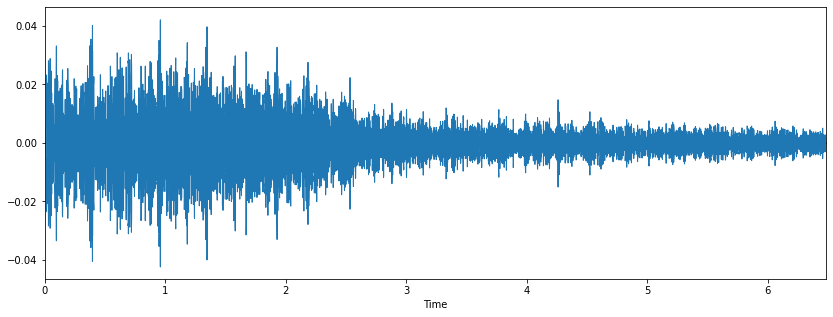

In [138]:
t0 = time.time()
cpt = aesccm.decrypt(nonce, cct, aad)
t1 = time.time()
print("Time taken to decrypt:",t1-t0,"seconds")
ccm_wav = np.frombuffer(cpt,dtype=numpy.float32)
sf.write('decrypted_file_ccm.wav', ccm_wav, sr)

with wave.open('decrypted_file_ccm.wav') as fd:
    params = fd.getparams()
    frames = fd.readframes(1000000) 
    
ccmd_x, ccmd_sr = librosa.load('decrypted_file_ccm.wav')

# decrypted values should match original file and representations
plt.figure(figsize=(14, 5))
librosa.display.waveplot(ccmd_x, sr=ccmd_sr)
ipd.Audio(ccmd_x, rate=ccmd_sr)

# Fernet (AES-CBC)

## Encryption

In [139]:
from cryptography.fernet import Fernet
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC

t0 = time.time()
password = b"password"
salt = os.urandom(16)
kdf = PBKDF2HMAC(algorithm=hashes.SHA256(),length=32,salt=salt,iterations=100000)
key = base64.urlsafe_b64encode(kdf.derive(password))
f = Fernet(key)
ct = f.encrypt(x_bytes)
t1 = time.time()
print("Time taken to encrypt:",t1-t0,"seconds")

fe_wav = numpy.frombuffer(ct,dtype=numpy.float32)
sf.write('encrypted_file_fernet.wav', fe_wav, sr)

Time taken to encrypt: 0.09710383415222168 seconds


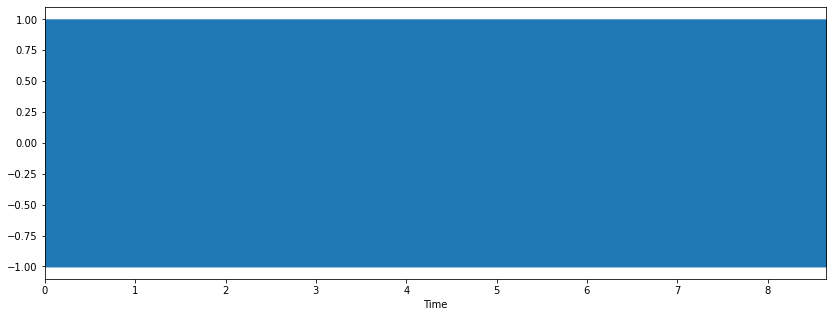

In [140]:
with wave.open('encrypted_file_fernet.wav') as fd:
    params = fd.getparams()
    frames = fd.readframes(1000000)
    
fe_x, fe_sr = librosa.load('encrypted_file_fernet.wav')

plt.figure(figsize=(14, 5))
librosa.display.waveplot(fe_x, sr=fe_sr)
ipd.Audio(fe_x, rate=fe_sr)

6 distinct values
Variance: 0.14187524


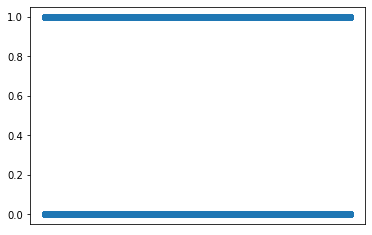

In [141]:
x = np.arange(0,len(fe_x))
y = fe_x

(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(len(frequencies), "distinct values")
print("Variance:", np.var(y))

plt.scatter(x, y, alpha=0.5)
plt.xticks([])
plt.show()

## Decryption

Time taken to decrypt: 0.006206989288330078 seconds


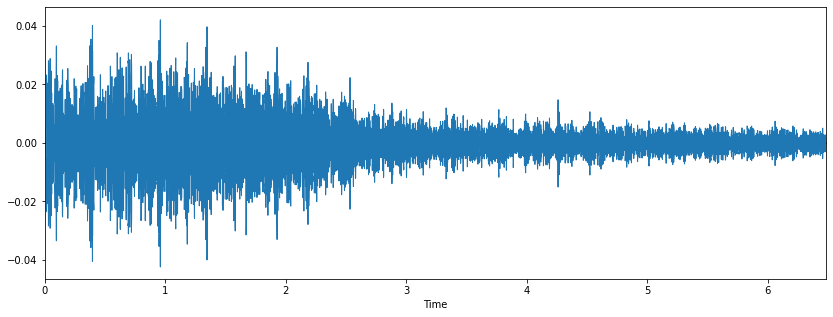

In [142]:
t0 = time.time()
decrypted = f.decrypt(ct)
t1 = time.time()
print("Time taken to decrypt:",t1-t0,"seconds")
df_wav = numpy.frombuffer(decrypted,dtype=numpy.float32)
sf.write('decrypted_file_fernet.wav', df_wav, sr)

with wave.open('decrypted_file_fernet.wav') as fd:
    params = fd.getparams()
    frames = fd.readframes(1000000)
    
fd_x, fd_sr = librosa.load('decrypted_file_fernet.wav')

# decrypted values should match original file and representations
plt.figure(figsize=(14, 5))
librosa.display.waveplot(fd_x, sr=fd_sr)
ipd.Audio(fd_x, rate=fd_sr)

### Python Library Versions
librosa: 0.8.1
matplotlib: 3.4.2
matplotlib-inline: 0.1.2
numpy: 1.21.0
Wave: 0.0.2